In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd

In [2]:
from utils import read_cleaned_ILI_tally

In [3]:
cleaned_ILI_tally_all = read_cleaned_ILI_tally()

Total rows = 2008441
Headers: ['Vendor', 'Source', 'Route', 'Route_NoPrefix', 'MP1', 'MP2', 'Year', 'ILI Project Name', 'ML Survey Date', 'Alignment Comment', 'Joint / US GW Number', 'ILI Survey Distance (ft)', 'Joint Length (ft)', 'From U/S GW (ft)', 'To D/S GW (ft)', 'Identification', 'Comment', 'Tool Speed (mph)', 'WT (in)', 'SMYS (PSI)', 'MAOP (PSI)', 'OD (in)', 'Longseam Visible', 'Seam Pos.', 'Depth (%)', 'Depth* (with tool tolerances)', 'OD Reduction (%)', 'Length (in)', 'Width (in)', "O'clock", 'Internal', 'Bend Radius (D)', 'Bend Angle (degrees)', 'Bend Direction', 'POF Category', 'Associated Tool Tolerance', 'Anomaly ID', 'Estimated Failure Pressure (Pf) ', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP', 'TotalBend Strain', 'Bend - Vert Strain Component', 'Bend - Horiz Strain Component', 'Internal Dent Strain', 'External Dent Strain', 'Easting', 'Northing', 'Latitude', 'Longitude', 'Elevation', 'U/S Reference', 'Dist. To U/S Ref [ft]', 'D/S Reference', 'Dist. To D/S Ref 

# Look at metal loss corrosion events

To determine wall loss due to corrosion, we look through the "Identification" field to eliminate all types other than "Manufacturing" related anomalies. The field corresponding to wall loss is "Depth (%)". So this is the one we care about.

The identification filtering step requires the following steps:

1. Convert to string
2. Remove all empty string/space
3. Remove all Identifications with "manufacturing" in it

In [73]:
unique_identifications = cleaned_ILI_tally_all["Identification"].dropna().astype(str).apply(lambda x: x.strip())
unique_identifications = unique_identifications.apply(lambda x: x.lower())
# remove empty str
empty_str_identification = unique_identifications == ''
unique_identifications = unique_identifications[~empty_str_identification]


In [85]:
# filter out all the rows whose identification is not in unique_identification
no_NA_identification_ILI = cleaned_ILI_tally_all.dropna(subset=["Identification"])
all_identification = no_NA_identification_ILI["Identification"].astype(str).apply(lambda x: x.strip()).apply(lambda x: x.lower())
is_ok_identification = all_identification.isin(unique_identifications)

In [137]:
ILI_with_cleaned_identification = no_NA_identification_ILI[is_ok_identification]
ILI_with_cleaned_identification["Identification"] = ILI_with_cleaned_identification["Identification"].astype(str).apply(lambda x: x.strip()).apply(lambda x: x.lower())

C:\Users\A1YU\AppData\Local\Temp\1\ipykernel_22952\2216992337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ILI_with_cleaned_identification["Identification"] = ILI_with_cleaned_identification["Identification"].astype(str).apply(lambda x: x.strip()).apply(lambda x: x.lower())


In [138]:
unique_identification_freq = ILI_with_cleaned_identification["Identification"].value_counts()
print(f"{np.sum(unique_identification_freq == 1) / len(unique_identification_freq)*100:.3f}% of all identifications has only 1 occurence")

94.892% of all identifications has only 1 occurence


In [139]:
manufacturing_mask = ["manufacturing" in category for category in unique_identification_freq.index]
print(f"Total {unique_identification_freq[manufacturing_mask].sum()} manufacturing Identifications")
print(f"Total {unique_identification_freq.sum()} Identifications")
print(f"{unique_identification_freq[manufacturing_mask].sum() / unique_identification_freq.sum() * 100: .3f}% of identifications are manufacturing related")

Total 139436 manufacturing Identifications
Total 1702946 Identifications
 8.188% of identifications are manufacturing related


In [152]:
mask = ILI_with_cleaned_identification["Identification"].isin(unique_identification_freq[manufacturing_mask].keys())
ILI_with_no_manufacturing_identification = ILI_with_cleaned_identification[~mask]
print(f"Total {len(ILI_with_no_manufacturing_identification)} non-manufacturing identifications")

Total 1563510 non-manufacturing identifications


In [153]:
# Now we have all corrosion-related rows, look at all Depth (%)
before_rows = len(ILI_with_no_manufacturing_identification)
ILI_with_no_manufacturing_identification = ILI_with_no_manufacturing_identification.dropna(subset=["Depth (%)"])
after_rows = len(ILI_with_no_manufacturing_identification)
print(f"{after_rows} non-manufacturing identifications with available Depth %, {before_rows - after_rows} dropped due to unavailable Depth %")
print(f"Proceeding on {after_rows / before_rows * 100: .3f}% of elgibile anomalies")

647945 non-manufacturing identifications with available Depth %, 915565 dropped due to unavailable Depth %
Proceeding on  41.442% of elgibile anomalies


In [154]:
# Display overall statistics
year_range = (ILI_with_no_manufacturing_identification["Year"].min(), ILI_with_no_manufacturing_identification["Year"].max())
wall_loss_perc = np.percentile(ILI_with_no_manufacturing_identification["Depth (%)"], [0, 5, 50, 95, 100])

In [184]:
from typing import Tuple

def plot_distribution_and_sd(data, xlabel=None, ylabel=None, title=None, ylog=True) -> Tuple[float, float, float, float, float]:
    sns.histplot(data, kde=True)
    mean = data.mean()
    std = data.std()
    one_sd, two_sd = std, 2 * std
    plt.axvline(mean - two_sd, color="red", linestyle="--", label=f"-2 SD = {mean-two_sd:.3f}%")
    plt.axvline(mean - one_sd, color="orange", linestyle="--", label=f"-1 SD = {mean-one_sd:.3f}%")
    plt.axvline(mean, color="green", linestyle="--", label=f"Mean({mean:.3f}%)")
    plt.axvline(mean + one_sd, color="red", linestyle="--", label=f"1 SD = {mean+one_sd:.3f}%")
    plt.axvline(mean + two_sd, color="orange", linestyle="--", label=f"2 SD = {mean+two_sd:.3f}%")
    plt.legend()
    if ylog:
        plt.yscale("log")
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    return (mean - two_sd, mean - one_sd, mean, mean + one_sd, mean + two_sd)

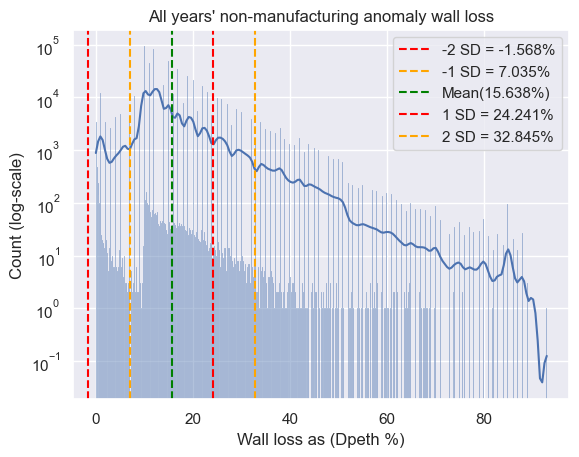

In [180]:
# Create a distribution plot

wall_loss_perc = ILI_with_no_manufacturing_identification["Depth (%)"]
(all_neg_2sd, all_neg_1sd, all_mean, all_pos_1sd, all_pos_2sd) = plot_distribution_and_sd(
    wall_loss_perc,
    xlabel="Wall loss as (Dpeth %)",
    ylabel="Count (log-scale)",
    title="All years' non-manufacturing anomaly wall loss"
)

# Let's break it out into years

In [166]:
unique_years = np.unique(ILI_with_no_manufacturing_identification["Year"])

In [167]:
year_mask = ILI_with_no_manufacturing_identification["Year"] == 2011
data = ILI_with_no_manufacturing_identification["Depth (%)"][year_mask]

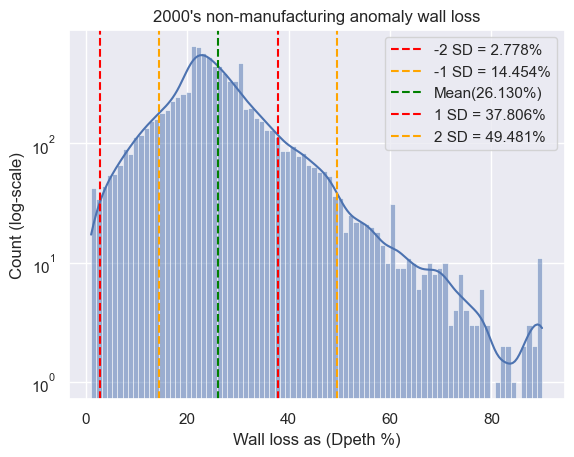

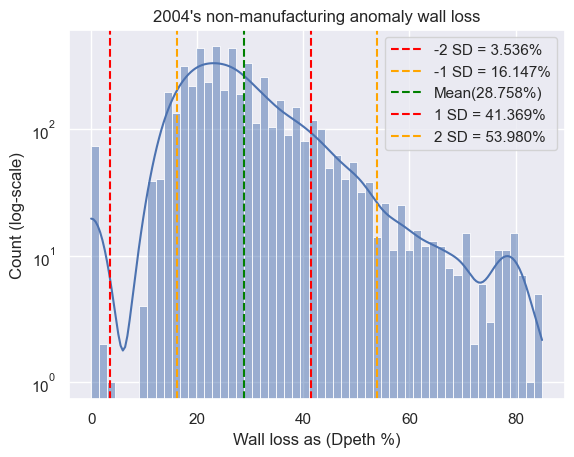

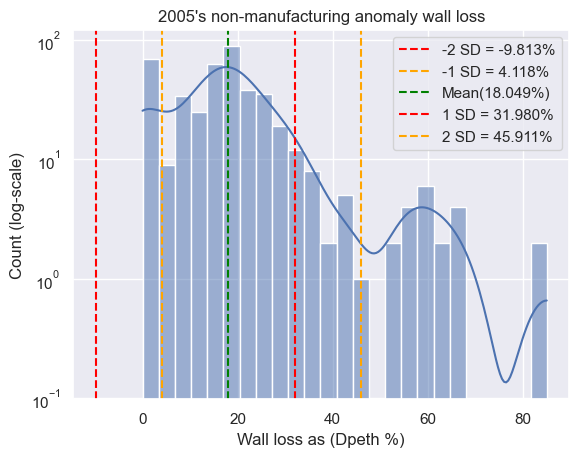

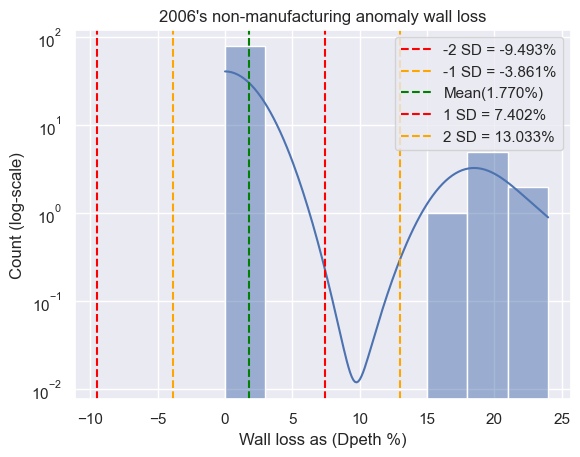

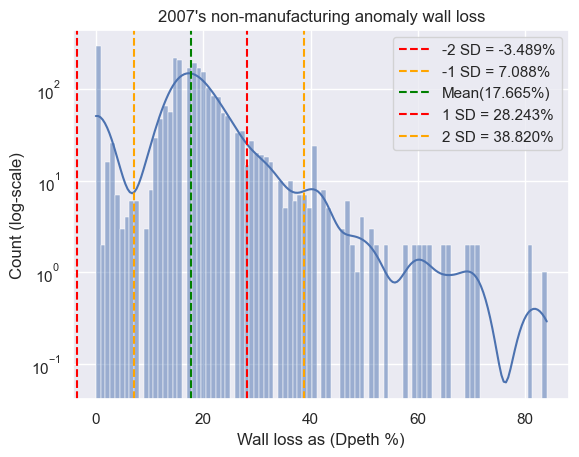

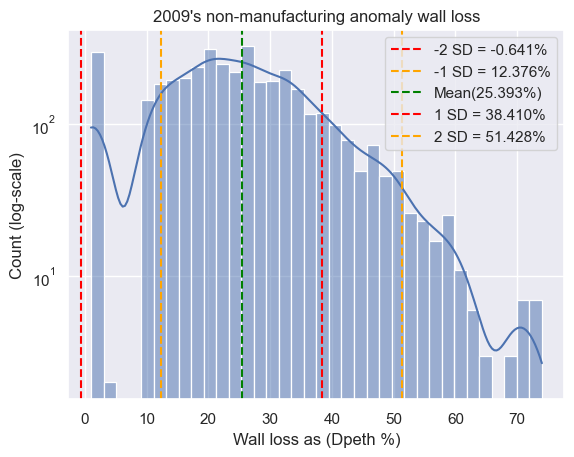

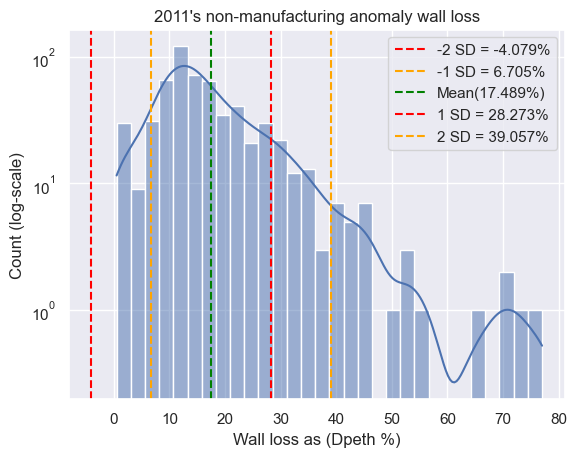

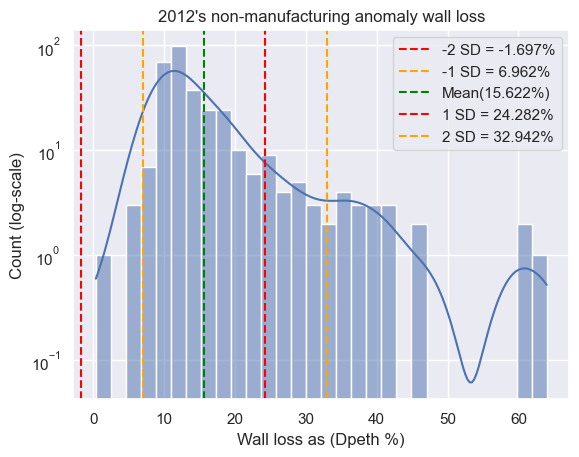

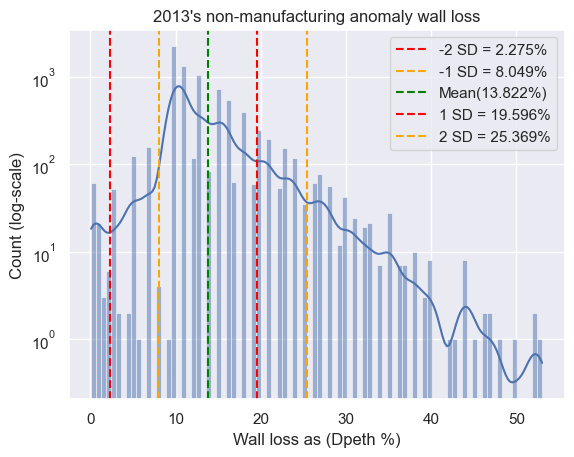

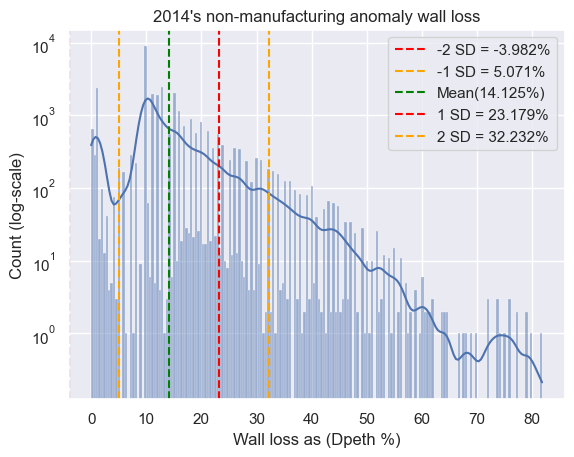

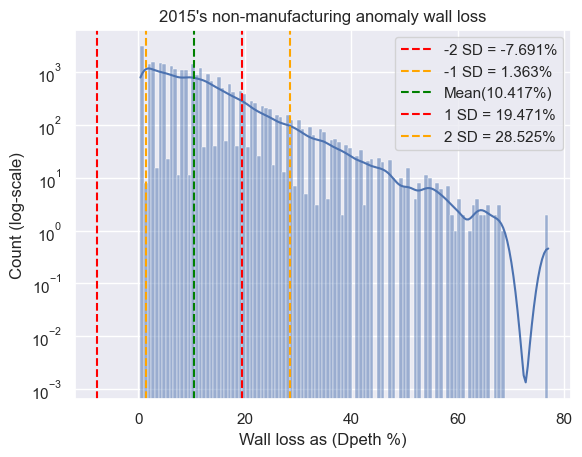

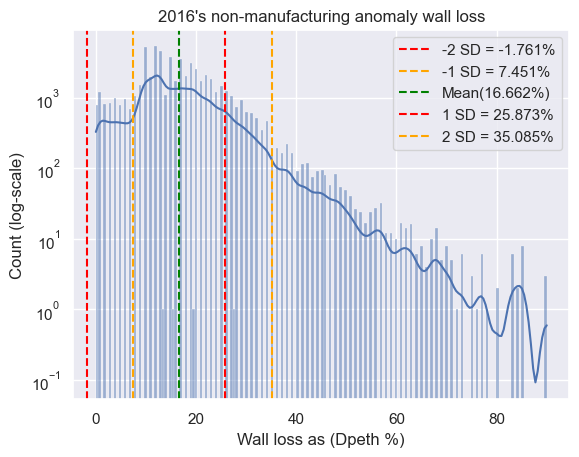

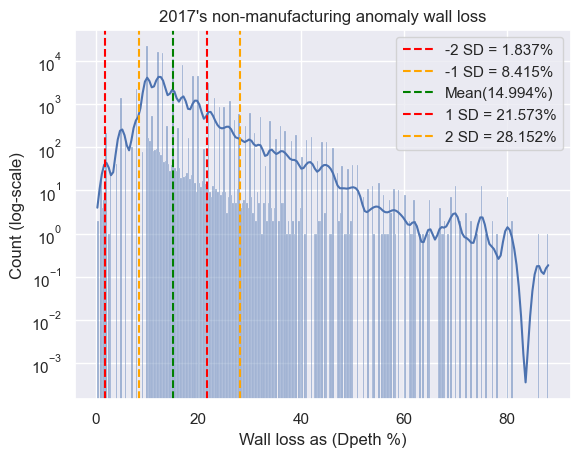

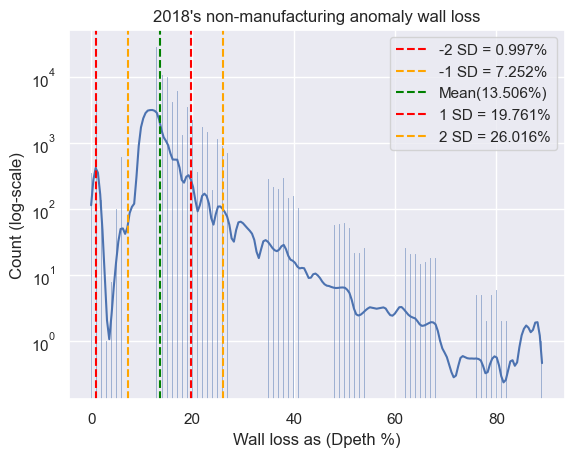

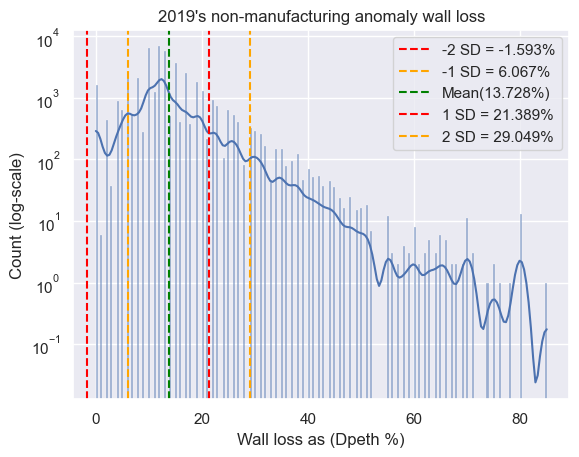

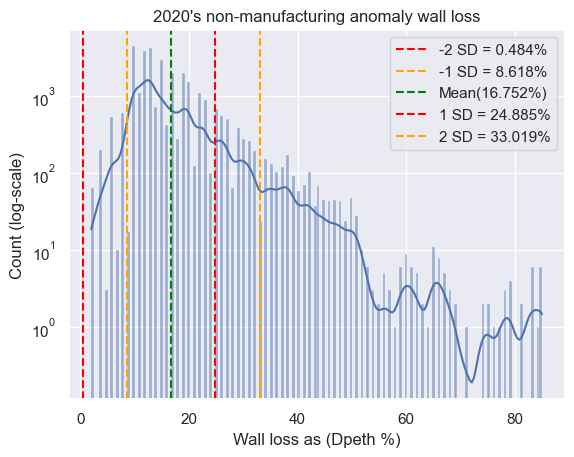

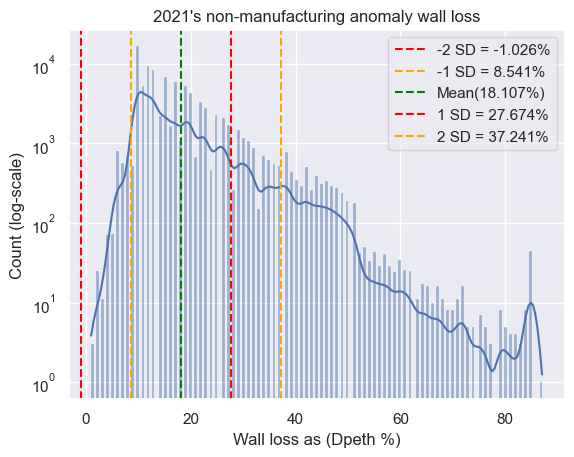

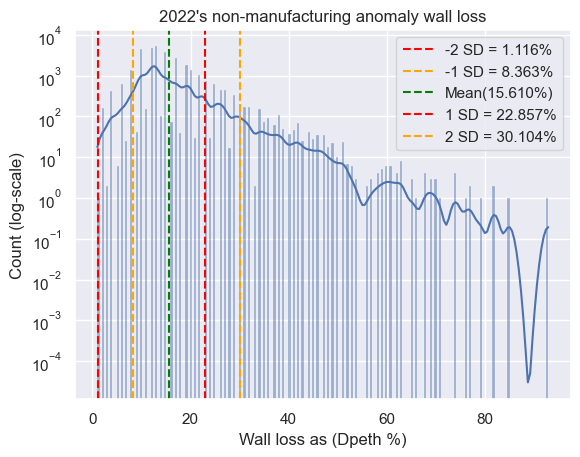

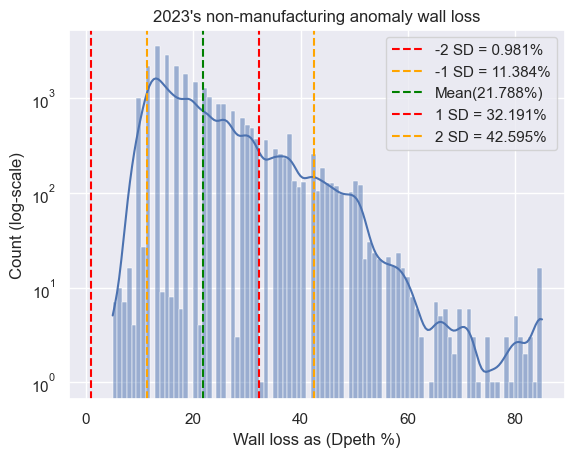

In [181]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

yearly_data = []
for year in unique_years:
    year_mask = ILI_with_no_manufacturing_identification["Year"] == year
    data = ILI_with_no_manufacturing_identification["Depth (%)"][year_mask]
    plt.figure()
    (neg_2sd, neg_1sd, mean, pos_1sd, pos_2sd) = plot_distribution_and_sd(
        data,
        xlabel="Wall loss as (Dpeth %)",
        ylabel="Count (log-scale)",
        title=f"{year}'s non-manufacturing anomaly wall loss"
    )
    yearly_data.append([neg_2sd, neg_1sd, mean, pos_1sd, pos_2sd])

In [182]:
yearly_data = np.array(yearly_data)

In [183]:
yearly_data

array([[ 2.77841003, 14.45411087, 26.12981172, 37.80551256, 49.4812134 ],
       [ 3.5361747 , 16.14712535, 28.758076  , 41.36902664, 53.97997729],
       [-9.81269979,  4.11824123, 18.04918224, 31.98012326, 45.91106428],
       [-9.49291844, -3.86140175,  1.77011494,  7.40163163, 13.03314832],
       [-3.48918299,  7.0881137 , 17.66541039, 28.24270707, 38.82000376],
       [-0.64110378, 12.37607008, 25.39324394, 38.4104178 , 51.42759166],
       [-4.07927003,  6.7048558 , 17.48898164, 28.27310747, 39.05723331],
       [-1.69728888,  6.9624891 , 15.62226708, 24.28204506, 32.94182304],
       [ 2.27495155,  8.04850761, 13.82206367, 19.59561973, 25.3691758 ],
       [-3.9820422 ,  5.07147845, 14.1249991 , 23.17851974, 32.23204039],
       [-7.690924  ,  1.36301871, 10.41696141, 19.47090411, 28.52484682],
       [-1.76076522,  7.45062167, 16.66200856, 25.87339545, 35.08478233],
       [ 1.83660937,  8.41546115, 14.99431293, 21.57316471, 28.15201648],
       [ 0.99727697,  7.25184338, 13.5

(15.528716769980853,
 25.449583729377387,
 35.37045068877392,
 45.291317648170455,
 55.21218460756699)

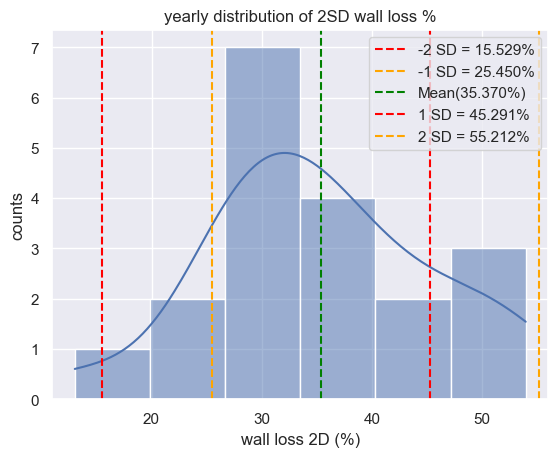

In [187]:
# plot the 2D distribution
plot_distribution_and_sd(yearly_data[:, -1], xlabel="wall loss 2D (%)", ylabel="counts", ylog=False, title="yearly distribution of 2SD wall loss %")